# Augment Line Strings

---

**Note**: The following document is very similar to the one for polygon augmentation. If you have already read that one, you can probably just quickly scroll through this one.

---

`imgaug` has native support for line string augmentation (currently in Beta state). A line string is a collection of many single line segments, with each having a start and end point. Line strings are -- in contrast to polygons -- not closed, i.e. no connection will be drawn or assumed between the first and last point of the whole line string.


## API

The following classes are relevant for line string augmentation:

### API: LineString

`imgaug.augmentables.lines.LineString(coords, [label])`: Container for a single line string. The `coords` are the points that (when connected) form the line string. They are provided as (sub-)pixel absolute coordinates. E.g. `LineString([(0, 0), (10, 0), (10, 10)])` creates a line string with a 90° angle at `x=10`, `y=0`.
* Properties offered by `LineString` are: `.coords` (all points), `.label` (the line string's class label, may be `None`), `.xx` (x-coordinates of all points), `.yy` (analogous), `.xx_int` (`.xx` rounded and cast to integers), `.yy_int` (analogous), `.height` (height of the line string), `.width` (analogous) and `.length` (euclidean distance between each pair of consecutive points).
* Methods offered by `LineString` are:
  * `get_pointwise_inside_image_mask(image)`: Generate for each point whether it is inside the provided image shape (`True`/`False`).
  * `compute_neighbour_distances()`: Generate a list of euclidean distances between consecutive points in `coords`.
  * `compute_pointwise_distances(other, default=None)`: Compute the distance from each point in `coords` to geometry `other` (e.g. another line string).
  * `compute_distance(other, default=None)`: Compute the minimum distance from any location on the line string to `other`.
  * `contains(other, max_distance=1e-4)`: Return whether `other` has a distance to the line string of less than `max_distance`.
  * `project(from_shape, to_shape)`: Project the line string from image shape `from_shape` onto image shape `to_shape`, i.e. change the point coordinates. This is useful when resizing images.
  * `is_fully_within_image(image, default=False)`: Estimate whether no part of the line string is outside of the given image plane.
  * `is_partly_within_image(image, default=False)`: Estimate whether any part of the line string is inside of the image plane.
  * `is_out_of_image(image, fully=True, partly=False, default=False)`: Estimate whether the line string is at least `partly` or `fully` outside of the image plane.
  * `clip_out_of_image(image)`: Remove all parts of the line string that are outside of the image plane. This can split line segment, creating new coordinates on the image edges. This also returns a list of 0 to N new line strings.
  * `find_intersections_with(other)`: Returns intersections with another object (one list of intersections per line segment).
  * `shift(top=None, right=None, bottom=None, left=None)`: Move the line string *from* the given side(s) by the given amount of pixels.
  * `draw_mask(image_shape, size_line=1, size_points=0, raise_if_out_of_image=False)`: Convert the line string to a binary mask with shape `image_shape`. An area around the line string of size `size_line` will be `True` in the mask.
  * `draw_line_heatmap_array(image_shape, alpha=1.0, size=1, antialiased=True, raise_if_out_of_image=False)`: Convert the line string to a heatmap array (float array, value range `[0.0, 1.0]`). This draws only the line segments of the line string, not the points.
  * `draw_points_heatmap_array(image_shape, alpha=1.0, size=1, raise_if_out_of_image=False)`: Convert the line string to a heatmap array (float array, value range `[0.0, 1.0]`). This draws only the point of the line string, not the line(s).
  * `draw_heatmap_array(image_shape, alpha_line=1.0, alpha_points=1.0, size_line=1, size_points=0, antialiased=True, raise_if_out_of_image=False)`: Combines `draw_line_heatmap_array()` and `draw_points_heatmap_array()`.
  * `draw_line_on_image(image, color=(0, 255, 0), alpha=1.0, size=3, antialiased=True, raise_if_out_of_image=False)`: Draw the line string's line segments in color on an `uint8` image.
  * `draw_points_on_image(image, color=(0, 128, 0), alpha=1.0, size=3, copy=True, raise_if_out_of_image=False)`: Draw the line string's points in color on an `uint8` image.
  * `draw_on_image(image, color=(0, 255, 0), color_line=None, color_points=None, alpha=1.0, alpha_line=None, alpha_points=None, size=1, size_line=None, size_points=None, antialiased=True, raise_if_out_of_image=False)`: Combines `draw_line_on_image()` and `draw_points_on_image()`.
  * `extract_from_image(image, size=1, pad=True, pad_max=None, antialiased=True, prevent_zero_size=True)`: Extract the area around the line string from an image. Will always return a rectangular `(H',W',C)` image array, but only the pixels belonging to the area will be non-zero.
  * `concatenate(other)`: Add `other`'s point(s) to this line string's points.
  * `subdivide(points_per_edge)`: Interpolates a given number of uniformly spaced new points on each line segment.
  * `to_keypoints()`: Return the line string's points as `Keypoint` instances.
  * `to_bounding_box()`: Return a bounding box containing all points of the line string.
  * `to_polygon()`: Return a polygon with the same points as this line string (but closed, as all polygons are closed). Note that the resulting polygon could be invalid (e.g. self-intersecting). If that is the case, some polygon methods would raise errors when called.
  * `to_heatmap(image_shape, size_line=1, size_points=0, antialiased=True, raise_if_out_of_image=False)`: Similar to `draw_heatmap_array()`, but returns a `HeatmapsOnImage` instance (instead of an array).
  * `to_segmentation_map(image_shape, size_line=1, size_points=0, antialiased=True, raise_if_out_of_image=False)`: Similar to `to_heatmap()` but returns a segmentation map instead (class `1` wherever the line string is, `0` everywhere else).
  * `coords_almost_equals(other, max_distance=1e-4, points_per_edge=8)`: Check whether the distance between the line string and `other` exceeds nowhere `max_distance`.
  * `almost_equals(other, max_distance=1e-4, points_per_edge=8)`: Like `coords_almost_equals()`, but also verifies that labels are identical.
  * `copy(coords=None, label=None)`: Creates a shallow copy of the line string.
  * `deepcopy(coords=None, label=None)`: Creates a deep copy of the line string.

### API: LineStringsOnImage

`imgaug.augmentables.lines.LineStringsOnImage(line_strings, shape)`: Container for a set of `LineString` instances placed on a single image. The image's shape must be provided as a tuple via the argument `shape` and is required during the augmentation to align line string and image augmentation (e.g. to sample corresponding crop values).
* Properties of `LineStringsOnImage` are: `.line_strings`, `.shape`, `.empty` (same as `len(.line_strings) == 0`).
* Methods of `LineStringsOnImage` are:
  * `on(self, image)`: Calls `project(...)` on each line string in `.line_strings`.
  * `from_xy_arrays()`: Creates a `LineStringsOnImage` instance from a list of xy-coordinate-arrays.
  * `to_xy_arrays()`: Returns a list of xy-coordinate-arrays making up each line string.
  * `draw_on_image(...)`: Calls `draw_on_image(...)` on each line string in `.line_strings`.
  * `remove_out_of_image(self, fully=True, partly=False)`: Removes all line strings from `.line_strings` that are partially and/or fully outside of the image plane.
  * `clip_out_of_image()`: Calls `clip_out_of_image()` on each line string in `.line_strings`. (This can increase the number of line strings.)
  * `shift(...)`: Calls `shift(...)` on each line string in `.line_strings`.
  * `copy()`: Currently an alias for `.deepcopy()`.
  * `deepcopy()`: Creates a deep copy of this instance.

### API: Augmentation Methods

Line strings can be augmented using `augment(images=<image data>, line_strings=<data>)`, which is offered by all augmenters. `<data>` is fairly tolerant and accepts many different inputs, e.g. a list of lists of `LineString` or a list of list of xy-coordinate-arrays. Alternatively, `augment_line_strings(line_strings_on_image)` can be used, which is also offered by all augmenters. It expects either a single instance of `LineStringsOnImage` or a list of it. It does *not* accept `LineString` instances, because these lack the necessary image shape information in the form of `.shape`.

Note that only augmentations that change the geometry affect line strings, e.g. affine transformations, cropping or horizontal flipping. Other augmentations, e.g. gaussian noise, only affect images.

### API: Docs

The [API](https://imgaug.readthedocs.io/en/latest/source/api.html) contains further details about line string classes and methods, see e.g. [LineString](https://imgaug.readthedocs.io/en/latest/source/api_imgaug.html#imgaug.augmentables.lines.LineString), [LineStringsOnImage](https://imgaug.readthedocs.io/en/latest/source/api_imgaug.html#imgaug.augmentables.lines.LineStringsOnImage), [Augmenter.augment()](https://imgaug.readthedocs.io/en/latest/source/api_augmenters_meta.html#imgaug.augmenters.meta.Augmenter.augment) and [Augmenter.augment_line_strings()](https://imgaug.readthedocs.io/en/latest/source/api_augmenters_meta.html#imgaug.augmenters.meta.Augmenter.augment_line_strings).

## Loading an Example Image and Creating Line Strings

We start by first loading an example image. We choose a random highway scene and will afterwards place two line strings that mark our vehicle's lane.

(451, 800, 3)


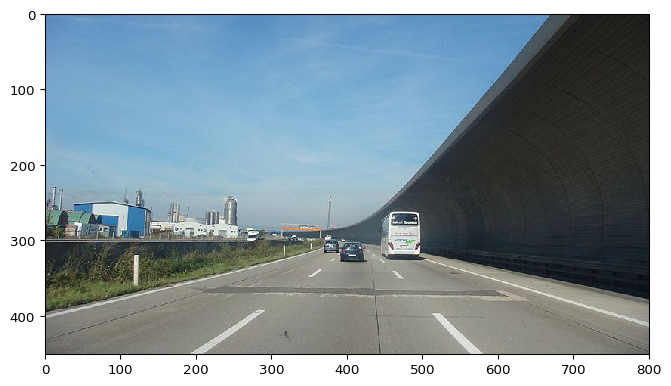

In [1]:
import imgaug as ia
import imageio
%matplotlib inline

image = imageio.imread("https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Ost_autobahn-2_-_panoramio.jpg/800px-Ost_autobahn-2_-_panoramio.jpg")
print(image.shape)
ia.imshow(image)

Now we place two line strings, one left of our vehicle and one on the right side of it. The LineString constructor expects xy-coordinates (in absolute pixels on the image), e.g. given as a list of `(x, y)` tuples or an `(N, 2)` numpy array. We use two lists. Then we combine the two created line strings to a `LinestringsOnImage()` instance, which is a container for all line strings on a single image (including that image's shape, which is necessary fpr some augmentation operations).

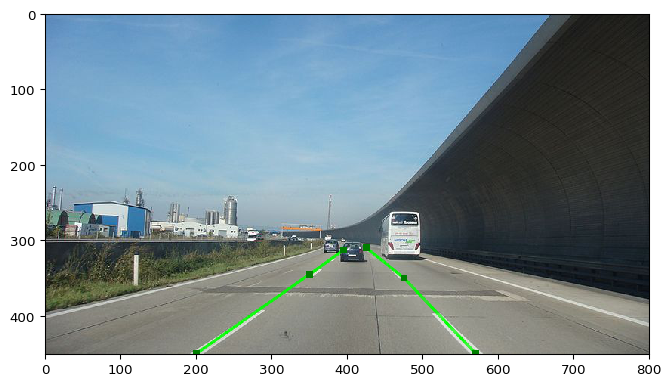

In [2]:
from imgaug.augmentables.lines import LineString, LineStringsOnImage

# line string left of vehicle
left_line = LineString([
    (200, 450), (350, 345), (395, 313)
])

# line string right of vehicle
right_line = LineString([
    (570, 450), (475, 350), (425, 310)
])

# combine all line strings on the same image
lsoi = LineStringsOnImage([left_line, right_line], shape=image.shape)

# draw line strings on image and show the result
ia.imshow(lsoi.draw_on_image(image, size=3))

## Augmenting the Example Image

Our next goal is to apply an augmentation to the loaded example image and the line strings that we just created. To do that, we first have to create a set of augmentation operations. We choose some color jittering, contrast changes, perspective transformation and translation:

In [3]:
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.AddToHueAndSaturation((30, 60)),
    iaa.LinearContrast((1.1, 1.2)),
    iaa.PerspectiveTransform((0.1, 0.2)),
    iaa.Affine(translate_px={"x": (20, 50)})
])

Next, we apply the augmentation operations to both image and line strings. To do that, we can simply call `image_aug, line_strings = seq(image=..., line_strings=...)`. `imgaug` will take care about all augmentation related tasks. Before applying the augmentations, we set the random number seed once via `ia.seed(...)` to ensure that the notebook will always behave similarly.

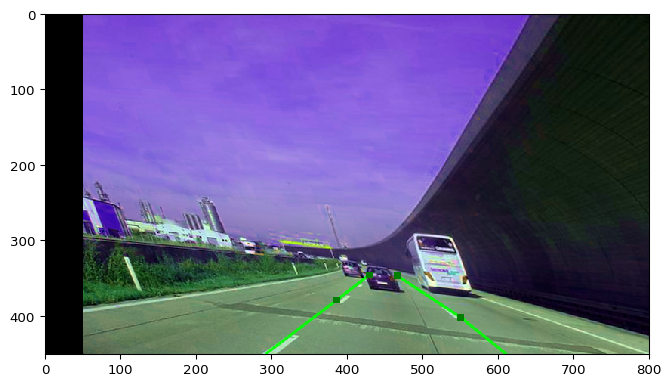

In [4]:
ia.seed(2)
image_aug, lsoi_aug = seq(image=image, line_strings=lsoi)
ia.imshow(lsoi_aug.draw_on_image(image_aug, size=3))

## Many Consecutive Augmentations

Let's now apply augmentations to more than one image. Before doing that, we define an alternative augmentation pipeline that adds some snow, fog and occasional darkness to the images.

In [5]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.AddToHueAndSaturation((-10, 10)),
    iaa.Affine(shear=(-8, 8), rotate=(-8, 8), scale=(1.0, 1.2), mode="edge"),
    iaa.Sometimes(0.7, iaa.FastSnowyLandscape(lightness_threshold=(100, 150), lightness_multiplier=(1.0, 3.0))),
    iaa.Snowflakes(),
    iaa.Sometimes(0.2, iaa.Clouds()),
    iaa.Sometimes(0.5, iaa.Alpha((0.5, 1.0), iaa.Fog())),
    iaa.Sometimes(0.3, [
        iaa.Multiply((0.2, 0.5)),
        iaa.GammaContrast(gamma=(1.2, 1.7))
    ])
])

Now we apply that sequence to a total of 16 images. One way to do that would be to call `seq(...)` once with 16 image arrays and 16 `LineStringsOnImage` instances, i.e. with one batch having batch size 16. Below, we will simply call `seq(...)` 16 times with each call containing a single image and line string. This is intended to show how one would use the method in real-world experiments that require handling of many batches in loops.

In [6]:
ia.seed(2)

# single batch with batch size > 1:
# images_aug = seq(images=[image] * 16, line_strings=[lsoi] * 16)

# many batches with each batch size 1:
images_aug = []
lsois_aug = []
for _ in range(16):
    # we are lazy here and simply reuse the same image and line strings
    # many times, but you could of course change these
    image_aug, lsoi_aug = seq(image=image, line_strings=lsoi)
    images_aug.append(image_aug)
    lsois_aug.append(lsoi_aug)

Now we draw each augmented `LineStringsOnImage` instance on the corresponding augmented image and plot the results.

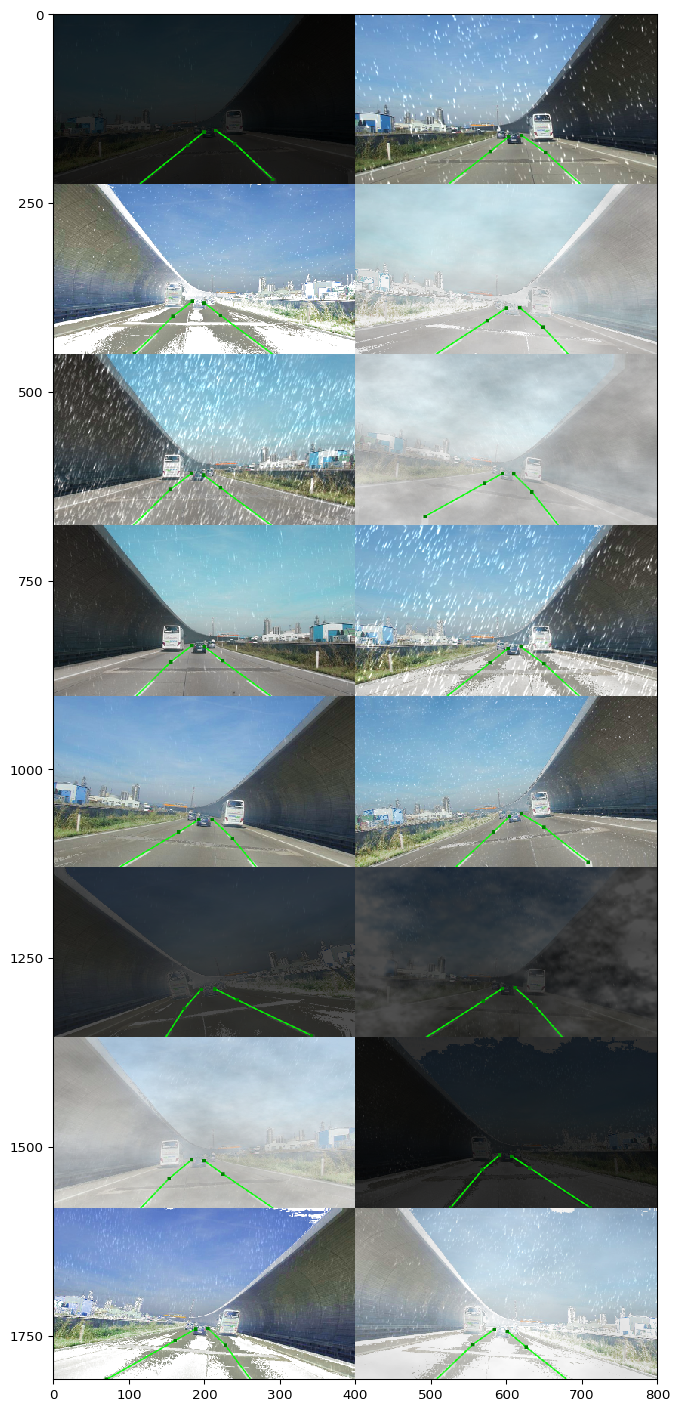

In [7]:
# draw augmented LineStringsOnImage instances on augmented images
images_drawn = [
    lsoi_aug.draw_on_image(image_aug, size=3)
    for image_aug, lsoi_aug
    in zip(images_aug, lsois_aug)
]

# decrease height/width of drawn images a bit
images_drawn_small = ia.imresize_many_images(images_drawn, 0.5)

# plot and show the 16 images in a grid
ia.imshow(ia.draw_grid(images_drawn_small, cols=2))

## Drawing Line Strings

The drawing methods have already been used above. This section will show some more examples. The primary methods for drawing are `LineString.draw_on_image()` and `LineStringsOnImage.draw_on_image()`, where the latter method simply iterates over each of `LineStringsOnImage`'s line strings and calls `LineString.draw_on_image()` on it.

Let's use again `LineString.draw_on_image()` with default arguments:

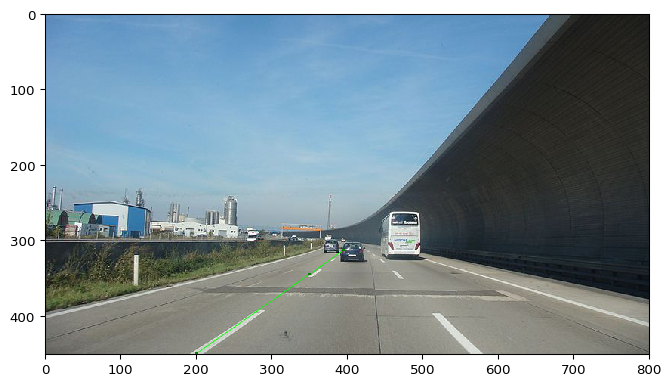

In [8]:
ia.imshow(left_line.draw_on_image(image))

We can change the size, color and opacity using the corresponding arguments `size`, `color` and `alpha`:

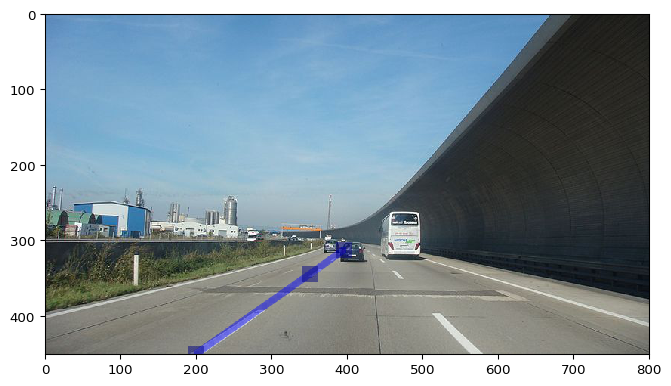

In [9]:
ia.imshow(left_line.draw_on_image(image, color=[0, 0, 255], size=7, alpha=0.5))

The drawing method will automatically derive from `color`, `size`, `opacity` arguments the color/size/opacity of the drawn line segments and points. However, the appearance of both line segments points can be individually fine tuned. E.g. use the arguments `color_line` and `color_points` for the line segment and point colors (analogous for size and alpha).

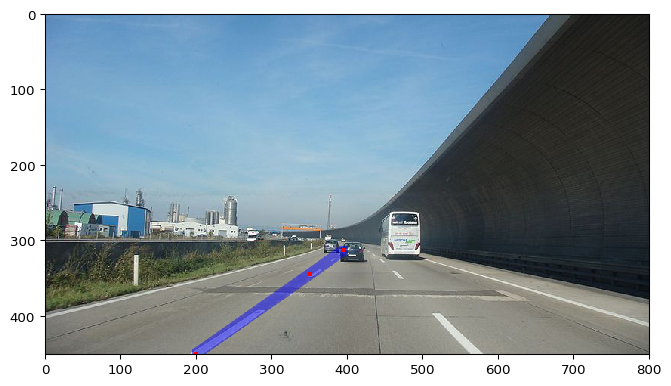

In [10]:
ia.imshow(left_line.draw_on_image(
    image,
    color_points=[255, 0, 0], color_line=[0, 0, 255],  # different color for line segments and points
    size_points=5, size_line=11,                       # different sizes
    alpha_points=1.0, alpha_line=0.5))                 # different opacities

If only the line (without points) is supposed to be drawn, you can also use `LineString.draw_line_on_image()`:

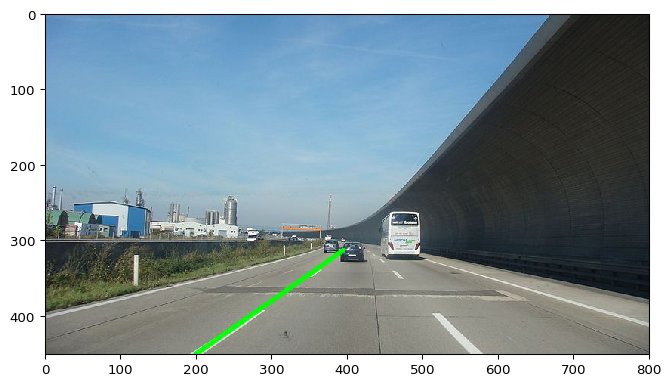

In [11]:
ia.imshow(left_line.draw_line_on_image(image, color=[0, 255, 0], size=5))

And analogously `LineString.draw_points_on_image()` can be used to draw only the points:

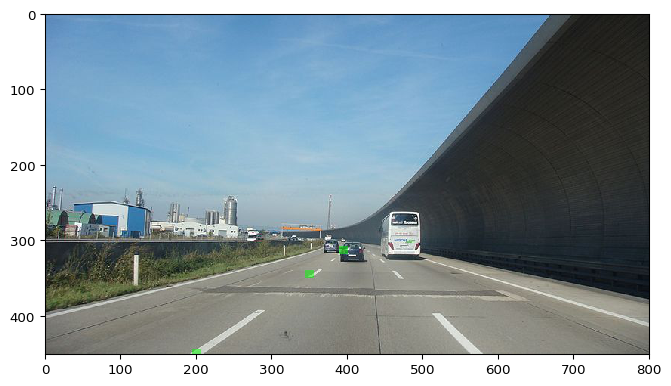

In [12]:
ia.imshow(left_line.draw_points_on_image(image, color=[0, 255, 0], size=11, alpha=0.5))

Aside from image drawing, there are also analogous methods to draw heatmap arrays for the line segments and/or points. These return `(H, W)` float arrays with values between `0.0` and `1.0`. Their arguments are mostly identical to the analogous image drawing routines. E.g. `LineString.draw_heatmap_array()` is comparable to `LineString.draw_on_image()`:

Shape: (451, 800) dtype: float32 min: 0.0 max: 1.0


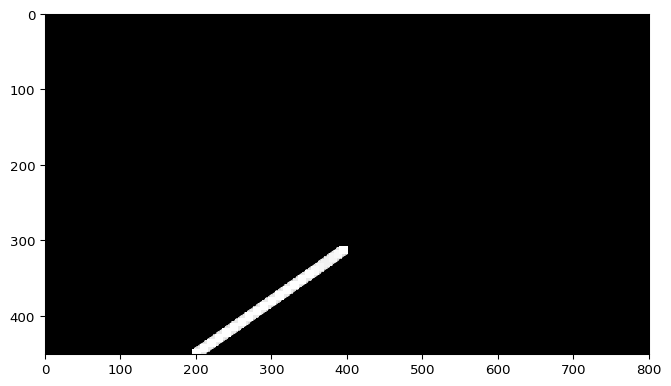

In [13]:
import numpy as np
arr = left_line.draw_heatmap_array(image.shape[0:2], size_line=11)
print("Shape:", arr.shape, "dtype:", arr.dtype, "min:", np.min(arr), "max:", np.max(arr))
ia.imshow(arr)

If a binary mask is required instead of a float array of range `[0.0, 1.0]`, one can use the method `LineString.draw_mask()`:

Shape: (451, 800) dtype: bool min: False max: True


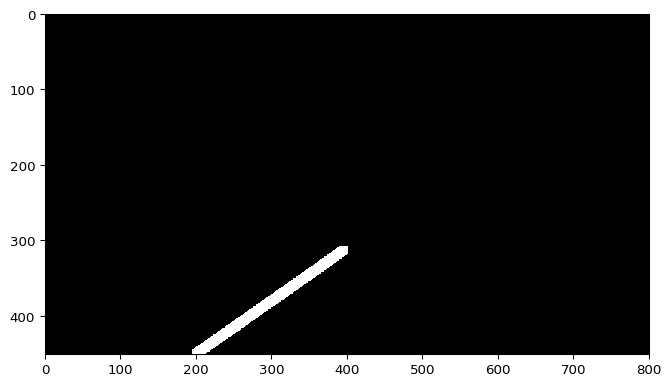

In [14]:
mask = left_line.draw_mask(image.shape[0:2], size_line=11)
print("Shape:", mask.shape, "dtype:", mask.dtype, "min:", np.min(mask), "max:", np.max(mask))
ia.imshow(mask)

## Extracting Image Content



The method `LineString.extract_from_image()` can be used to extract the line string's pixels from the image. Use `size=<int>` to define the thickness of the line string and hence how many pixels around it are going to be extracted. By default, empty pixels will be padded to the image if the line string's points are outside of the image plane or if the `size` setting will lead to the line string extending beyond the image plane. Use `pad=False` to disable that auto-padding. If the extracted area is empty (e.g. due to the line string not containing any points), the extract method will by default still return an empty numpy array of shape `(1, 1, C)`. Use `prevent_zero_size=False` to allow shapes down to `(0, 0, C)`.

The following example extracts the line string and some area around it from the image:

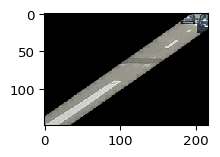

In [15]:
extract = left_line.extract_from_image(image, size=21, pad=False)
ia.imshow(extract)

As can be seen, the resulting array size may be smaller than the size of the image. If you don't want that or want to merely highlight the line string's pixels, you can make use of `LineString.draw_line_heatmap_array()` and multiply the image with that generated heatmap, thereby zero-ing pixels outside of the line string's area:

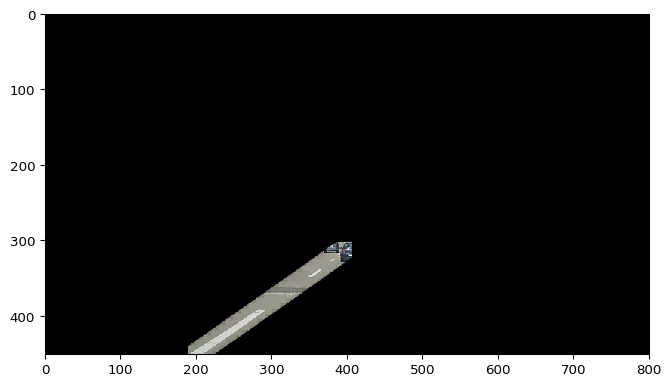

In [16]:
heatmap = left_line.draw_line_heatmap_array(image.shape[0:2], size=21)
highlighted = image * np.atleast_3d(heatmap)
ia.imshow(highlighted.astype(np.uint8))

To merely highlight the line string's area, simply clip the heatmap to a minimum value (here, `0.1`):

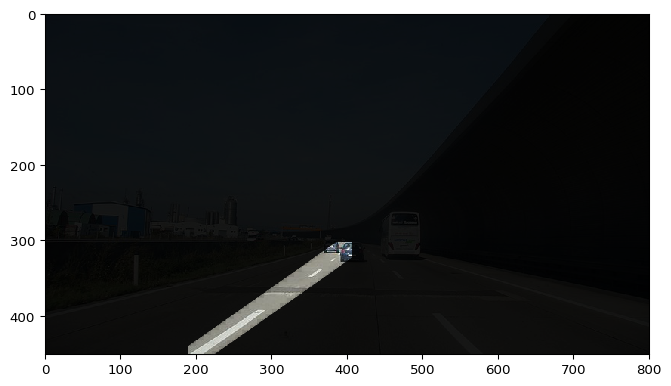

In [17]:
heatmap = left_line.draw_line_heatmap_array(image.shape[0:2], size=21)
heatmap = np.clip(heatmap, 0.1, 1.0)  # added line, everything else is the same as above
highlighted = image * np.atleast_3d(heatmap)
ia.imshow(highlighted.astype(np.uint8))

## Clipping Line Strings

If you have a line string that leaves the image plane (or *might* do so) and you want to restrict it to the parts of it that are within the image plane, you can use `LineString.clip_out_of_image(image)` or `LineStringsOnImage.clip_out_of_image(image)`. The former method returns a list of `LineString` instances (the list can be empty), the latter method returns a new `LineStringsOnImage` instance with updated `.line_strings` property. In both cases a clipped line string can be split into multiple new line strings. Each of these new line strings is then guarantueed to be within `[0, width)` for its x-coordinates and `[0, height)` for its y-coordinates. Note that this can also mean that a point ends up with x-coordinate `9.999` for an image with width `10`, which can lead to the point being again outside of the image plane after rounding to integers.

As an example, let's create a line string that starts outside of the example image (on its left), has its second point again outside of the example image (on its right) and its third point inside the image plane. This line string intersects with the image edges at three different locations.

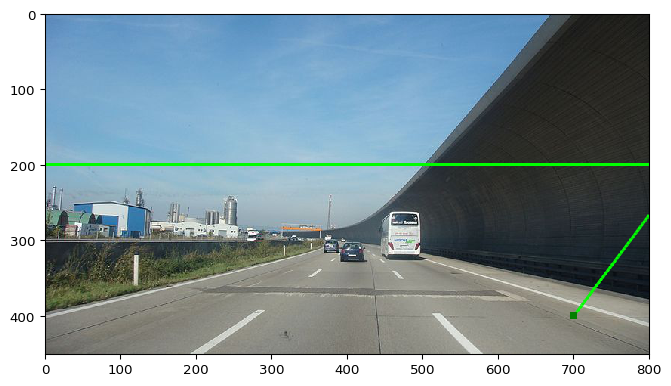

In [18]:
ls = LineString([(-50, 200), (850, 200), (700, 400)])
ia.imshow(ls.draw_on_image(image, size=3))

We can also visualize the full line string, by padding both the image and the line string before drawing:

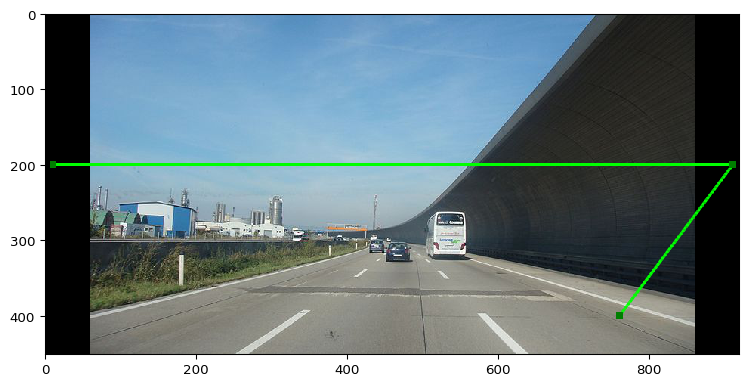

In [19]:
ia.imshow(
    ls.shift(left=60).draw_on_image(
        ia.pad(image, left=60, right=60),
        size=3
    )
)

We now clip the line string using `LineString.clip_out_of_image()`:

In [20]:
lss_clipped = ls.clip_out_of_image(image)

The result of this is a list of new `LineString`s:

In [21]:
print("Type: ", type(lss_clipped))
print("Length: ", len(lss_clipped))
for ls_clipped in lss_clipped:
    print(ls_clipped.coords)

Type:  <class 'list'>
Length:  2
[[  0.    200.   ]
 [799.999 200.   ]]
[[799.999   266.66797]
 [700.      400.     ]]


Note how there are now x-coordinates exactly matching `x=0` and `x=<width of image> - epsilon`. The points outside of the image plane are gone. By clipping, we turned the original line string into two line strings, based on where it intersected with the image edges.

Let's visualize the new line strings:

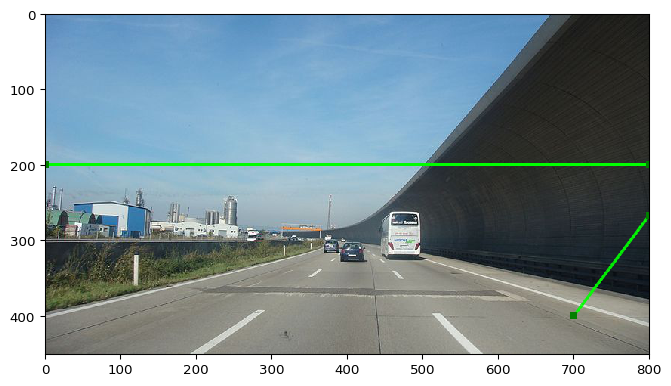

In [22]:
ia.imshow(
    LineStringsOnImage(lss_clipped, shape=image.shape).draw_on_image(image, size=3)
)

`LineString` also offers simple methods to quickly tell whether a line string is completely inside an image plane (`.is_fully_within_image()`), at least partially inside it (`.is_partly_within_image()`) or is completely outside of it (`is_out_of_image()`). We can apply these to the original line string before clipping:

In [23]:
print("fully within image:    ", ls.is_fully_within_image(image))
print("partially within image:", ls.is_partly_within_image(image))
print("fully out of image:    ", ls.is_out_of_image(image, fully=True, partly=False))
print("partially out of image:", ls.is_out_of_image(image, fully=False, partly=True))

fully within image:     False
partially within image: True
fully out of image:     False
partially out of image: True


The results are as expected. The original line string was partially inside the image, with some parts leaving it.
Applying the same methods to the clipped line strings shows that these are now fully inside the image plane:

In [24]:
for ls_clipped in lss_clipped:
    print("fully within image:    ", ls_clipped.is_fully_within_image(image))
    print("partially within image:", ls_clipped.is_partly_within_image(image))
    print("fully out of image:    ", ls_clipped.is_out_of_image(image, fully=True, partly=False))
    print("partially out of image:", ls_clipped.is_out_of_image(image, fully=False, partly=True))
    print("")

fully within image:     True
partially within image: True
fully out of image:     False
partially out of image: False

fully within image:     True
partially within image: True
fully out of image:     False
partially out of image: False



Instead of clipping line strings, we could also remove the ones that are outside of the image plane. This is done using `LineStringsOnImage.remove_out_of_image(image)`. As an example, we create a `LineStringsOnImage` instance that only contains our line string that has two of three points outside of the image plane:

In [25]:
lsoi_example = LineStringsOnImage([ls], shape=image.shape)
print(lsoi_example)

LineStringsOnImage([LineString([(-50.00, 200.00), (850.00, 200.00), (700.00, 400.00)], label=None)], shape=(451, 800, 3))


We now first remove all line strings within the `LineStringsOnImage` instance that are *fully* outside of the image plane (this is the default behaviour of `remove_out_of_image()`). This affects no line strings as our example line string is partially inside the image. Afterwards, we remove all line strings that are at least *partially* outside of the image plane. This removes our example line string.

In [26]:
print(lsoi_example.remove_out_of_image(fully=True, partly=False))
print(lsoi_example.remove_out_of_image(fully=True, partly=True))

LineStringsOnImage([LineString([(-50.00, 200.00), (850.00, 200.00), (700.00, 400.00)], label=None)], shape=(451, 800, 3))
LineStringsOnImage([], shape=(451, 800, 3))


## Concatenating Line Strings

The method `LineString.concatenate(...)` can be used to concatenate a line string with another object `other`, where `other` can be again a `LineString` instance, an `(N,2)` array, a list of `Keypoint` instances or a list of `(x, y)` tuples.

Here, we concatenate the line string right of the vehicle to the one left of the vehicle:

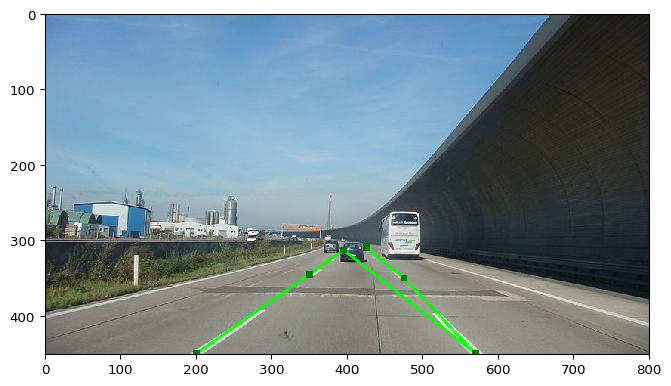

In [27]:
ls_both = left_line.concatenate(right_line)
ia.imshow(ls_both.draw_on_image(image, size=3))

We can also add a single point by wrapping it in a list:

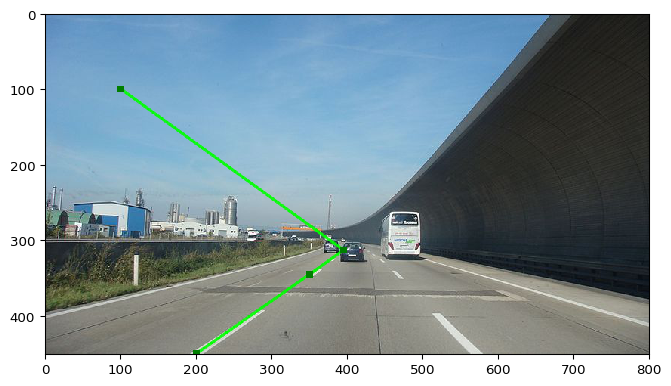

In [28]:
ls_concat = left_line.concatenate([(100, 100)])
ia.imshow(ls_concat.draw_on_image(image, size=3))

## Projecting Line Strings onto other Images and Shifting Them

The coordinates of line strings are represented as absolute pixel values. As a result, the coordinates are off whenever the corresponding image is up- or downscaled. This can however easily be circumvented using `LineString.project(old_shape, new_shape)` or `LineStringsOnImage.on(new_shape)`. Both of these methods return new class instances with coordinates projected to the new image size.

To show these methods in action, let's first downscale the example image to a quarter of its original size:

In [29]:
image_small = ia.imresize_single_image(image, 0.25)

We use `LineString.project()` to project the left line's coordinates from the original image shape to the shape of the downscaled image:

In [30]:
print("Original image shape and coordinates:  ", image.shape, left_line.coords)
print("Downscaled image shape and coordinates:", image_small.shape, left_line.project(image, image_small).coords)

Original image shape and coordinates:   (451, 800, 3) [[200. 450.]
 [350. 345.]
 [395. 313.]]
Downscaled image shape and coordinates: (113, 200, 3) [[ 50.      112.74944]
 [ 87.5      86.44124]
 [ 98.75     78.4235 ]]


New let's compare visually the effects of using and *not* using the project functions. This time we project both line strings using `LineStringsOnImage.on(<shape of downscaled image>)`. The left image shows the line strings on the downscaled image without projecting them to the new image size. The right image shows them with projection. As can be seen, the line strings are missing from the left image because they would be placed too far to the bottom right. On the right image, they are placed accurately.

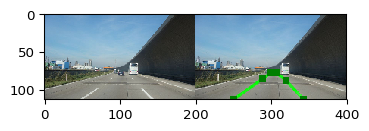

In [31]:
lsoi_proj = lsoi.on(image_small)
ia.imshow(
    np.hstack([
        lsoi.draw_on_image(image_small, size=3),
        lsoi_proj.draw_on_image(image_small, size=3)
    ])
)

With a bit of image padding we can visualize the unprojected line strings that are missing in the above left image:

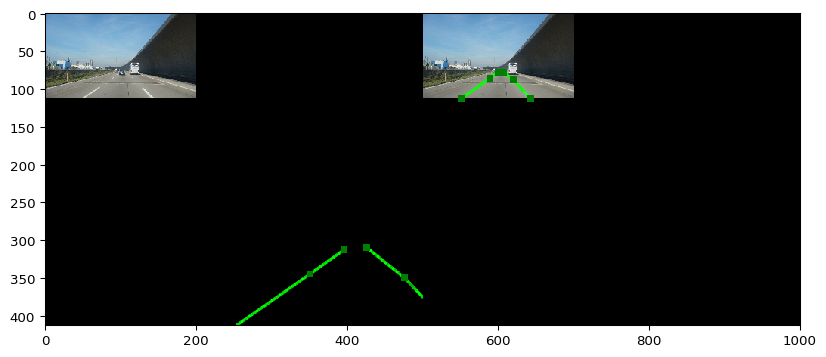

In [32]:
image_small_pad = ia.pad(image_small, right=300, bottom=300)
ia.imshow(
    np.hstack([
        lsoi.draw_on_image(image_small_pad, size=3),
        lsoi_proj.draw_on_image(image_small_pad, size=3)
    ])
)

Simple projection only works when placing the line strings on resized images, not when placing them on padded or completely different images. In these cases, you might want to simply shift the line strings, e.g. to compensate for padding. This can be done using `LineString.shift(top=<by pixels>, right=<by pixels>, bottom=<by pixels>, top=<by pixels>)` or analogously `LineStringsOnImage.shift(...)`. Both methods shift *from* the respective side, not towards it. E.g. `top=10` shifts the line strings 10px towards the bottom.

In the following example we shift our two standard line strings by a few pixels towards the bottom right:

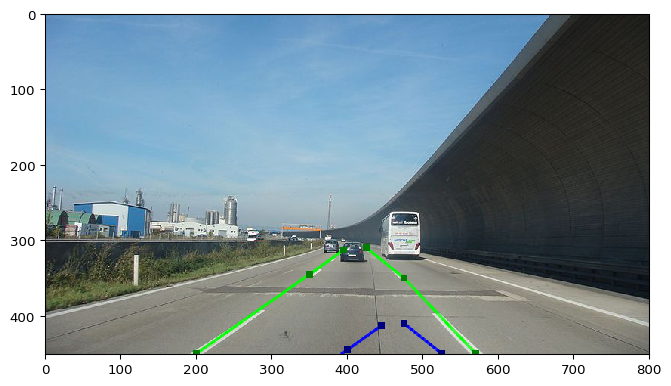

In [33]:
# shift both line strings by 50px from the left and 100px from the top
lsoi_shifted = lsoi.shift(left=50, top=100)

# draw the line strings before (green) and after (blue) shifting on the image
image_drawn = lsoi.draw_on_image(image, color=[0, 255, 0], size=3)
image_drawn = lsoi_shifted.draw_on_image(image_drawn, color=[0, 0, 255], size=3)

# visualize the results
ia.imshow(image_drawn)

## Computing Height, Width and Length of Line Strings

In case you ever need it, you can easily retrieve the height/width and length of each line string using `.height`, `.width` and `.length`. The height/width denote the difference between the min and max y/x coordinates (and may return `0` if the line string does not contain coordinates). The length denotes the sum of euclidean distances between its points (and may also return `0` if the line string does not contain any points).

In [34]:
print(
    left_line.height,
    left_line.width,
    left_line.length
)
print(
    right_line.height,
    right_line.width,
    right_line.length
)

137.0 195.0 238.31607
140.0 145.0 201.96237


## Computing Distances

Distances from the line string to other line strings or points can be computed using `LineString.compute_distance(other)`. The distance always represents the euclidean distance between the two closest points on both objects.

Example for computing the distance to another line string:

In [35]:
print(left_line.compute_distance(right_line))

30.14962686336267


Example for computing the distance to another point:

In [36]:
print(left_line.compute_distance((0, 0)))

491.4519305079592


You can also compute a list of distances, one per coordinate in the line string (from that coordinate to the closest point on the other object):

In [37]:
print(left_line.compute_pointwise_distances((0, 0)))

[492.44289008980525, 491.4519305079592, 503.97817413058675]


## Converting Line Strings to other Data Types

Line strings can be converted to various other objects, including arrays, lists of `Keypoint`, bounding boxes, polygons, heatmaps and segmentation maps.

The coordinates of a single `LineString` are already saved as a numpy array. Hence they can easily be "converted" to an array using `LineString.coords`:

In [38]:
arr = left_line.coords
print(arr)

[[200. 450.]
 [350. 345.]
 [395. 313.]]


If you only need the x- or y-coordinates, you can also call the properties `.xx` or `.yy`. The properties `.xx_int`, `.yy_int` return the corresponding integer coordinates (including rounding).

To get all coordinate arrays within a `LineStringsOnImage` instance, call `LinesStringsToImage.to_xy_arrays()`:

In [39]:
arrs = lsoi.to_xy_arrays()
for arr in arrs:
    print(arr)

[[200. 450.]
 [350. 345.]
 [395. 313.]]
[[570. 450.]
 [475. 350.]
 [425. 310.]]


To convert the points of a line string to a list of `Keypoint` instances, call `LineString.to_keypoints()`:

[Keypoint(x=200.00000000, y=450.00000000), Keypoint(x=350.00000000, y=345.00000000), Keypoint(x=395.00000000, y=313.00000000)]


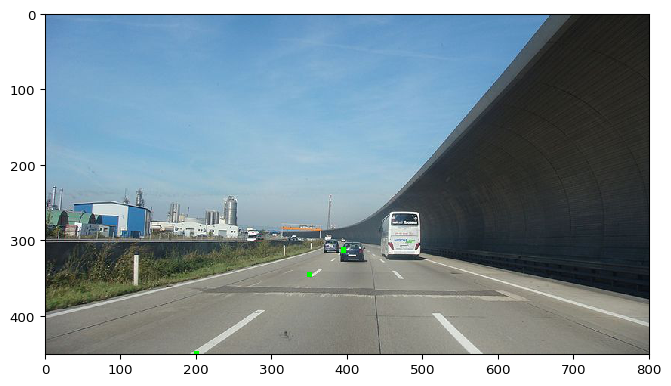

In [40]:
kps = left_line.to_keypoints()
print(kps)
ia.imshow(ia.KeypointsOnImage(kps, shape=image.shape).draw_on_image(image, size=7))

To generate a bounding box containing all points of a line string, call `LineString.to_bounding_box()`:

BoundingBox(x1=200.0000, y1=313.0000, x2=395.0000, y2=450.0000, label=None)


/home/aj/software/anaconda3/envs/imgaug37/lib/python3.7/site-packages/imgaug/augmentables/bbs.py:548: DeprecationWarning: Usage of argument 'thickness' in BoundingBox.draw_on_image() is deprecated. The argument was renamed to 'size'.
  "Usage of argument 'thickness' in BoundingBox.draw_on_image() "


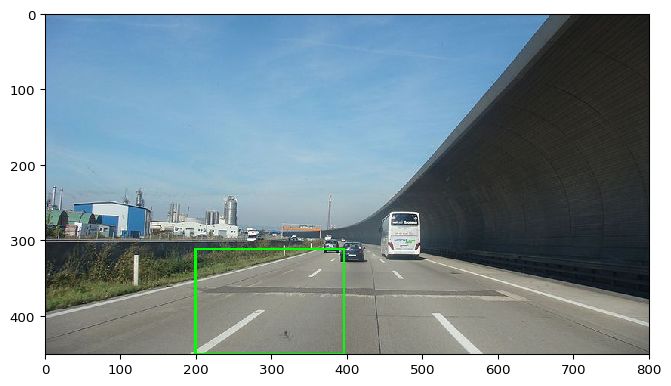

In [41]:
bb = left_line.to_bounding_box()
print(bb)
ia.imshow(bb.draw_on_image(image, thickness=3))

To convert the points of a line string to a `Polygon` instance, call `LineString.to_polygon()`:

Polygon([(x=200.000, y=450.000), (x=350.000, y=345.000), (x=395.000, y=313.000)] (3 points), label=None)


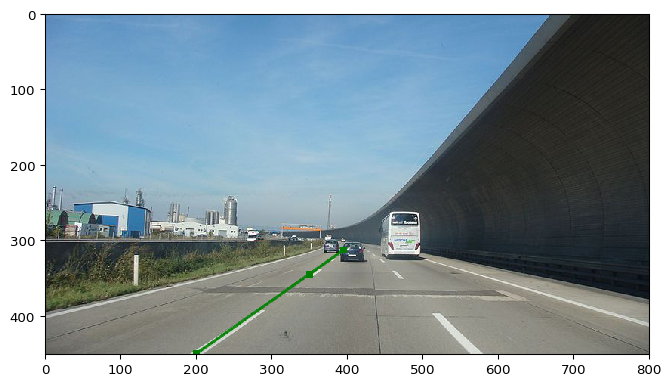

In [42]:
poly = left_line.to_polygon()
print(poly)
ia.imshow(poly.draw_on_image(image, size=3))

Note that line strings and polygons are very similar to each other. Polygons are closed in contrast to line strings. Here, it is hard to see that the polygon is closed as a line from the end to the start point of the line strings strongly overlaps with the line segments from the start to the end point.

You can also convert a line string to a `HeatmapsOnImage` instance, which contains an array of floats between `0.0` to `1.0`. This can be used to then apply augmentations to the heatmap. You can get the heatmap array using `HeatmapsOnImage.arr_0to1`. See also the jupyter notebook on heatmap augmentation for more details. Also see further above, in the "drawing" section, the similar heatmap drawing methods.

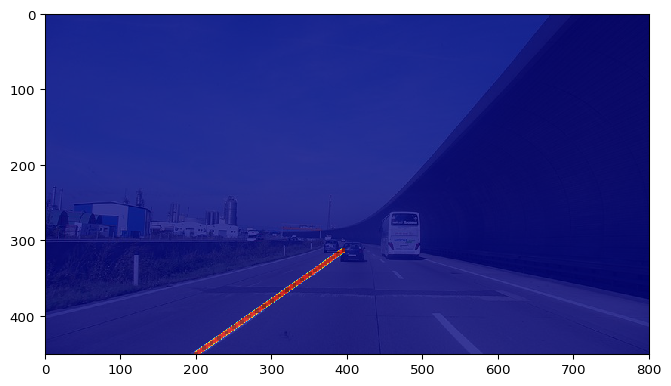

In [43]:
heatmap = left_line.to_heatmap(image.shape[0:2], size_line=5)
# we use [0] here, as HeatmapsOnImage.draw_on_image() returns a list of images, one per heatmap channel
ia.imshow(heatmap.draw_on_image(image)[0])

Comparably to the above `to_heatmaps()`, each `LineString` can also be converted to a `SegmentationMapOnImage` instance using `to_segmentation_map()`:

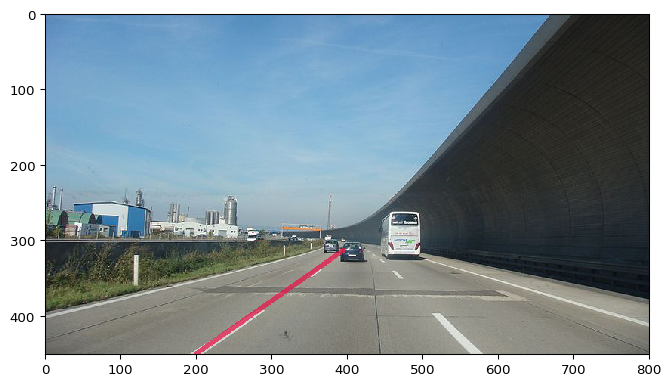

In [44]:
segmap = left_line.to_segmentation_map(image.shape[0:2], size_line=5)
ia.imshow(segmap.draw_on_image(image))

## Comparing Line Strings

In the rare case that you have to compare line strings with each other, you can do so using `LineString.coords_almost_equals(other, [distance_threshold], [points_per_edge])` and `LineString.almost_equals(other, [distance_threshold], [points_per_edge])`. The first method only performs a distance-based comparison. For two line strings `A` and `B` it returns `True` if the maximum distance from any location on `A` to the closest location on `B` is below a threshold. (This is an approximate test that decreases the probability of errors by interpolating more points on each edge.) The second method additionally compares the `.label` attributes.

Examples:

In [45]:
# left line string similar to the left line string?
print(left_line.coords_almost_equals(left_line))

True


In [46]:
# left line string similar to the left right string?
print(left_line.coords_almost_equals(right_line))

False


In [47]:
# left line string similar to the left line string *after* shifting it from the left by 1px?
print(left_line.coords_almost_equals(left_line.shift(left=1)))

False


In [48]:
# left line string similar to the left line string *after* shifting it from the left by 1px
# AND using a distance threshold of 1px (distances >= threshold are interpreted as too far
# away to be considered similar)
print(left_line.coords_almost_equals(
    left_line.shift(left=1),
    max_distance=1
))
# same as above, but now with distance threshold of 1.0001px
print(left_line.coords_almost_equals(
    left_line.shift(left=1),
    max_distance=1 + 1e-4
))

False
True


In [49]:
# 'label' attribute affects the results when using 'almost_equals()' instead of 'coords_almost_equals()'
line1 = LineString([(0, 0), (1, 0)], label="example")
line2 = LineString([(0, 0), (1, 0)], label="example")
line3 = LineString([(0, 0), (1, 0)], label="example-2")

print(line1.almost_equals(line2))
print(line1.almost_equals(line3))

True
False
